In this notebook, I explore models for estimating survival using capture-recapture data in PyMC. Arguably, the two most common models are the Cormack-Jolly-Seber (CJS) and Jolly-Seber-Shwarz-Arnason (JSSA) models. The primary difference between the two is that the JSSA model also tries to estimate the probability of entry into the population, which permits esimation of the superpopulation size.

In this notebook, I have drawn considerable inspiration from Austin Rochford's [notebook on capture-recapture in PyMC](https://austinrochford.com/posts/2018-01-31-capture-recapture.html), [the second chapter of my dissertation](https://github.com/philpatton/autocapture)--a work in progress, and @mccrea2014. 

# Cormack-Jolly-Seber 

First, I explore fitting the Cormack-Jolly-Seber (CJS) model in PyMC. The CJS framework does not model entrance into the population, just survival, simplifying the model structure. There are many methods for estimating parameters in the model, including state-space formulations that explicitly model the latent alive/dead state $z.$ Following the theme of the previous notebooks, I instead marginalize this variable out of the model by using the so-called $M$-array. This is an array that contains the sufficient statistics for the CJS and JSSA models. For example, $m_{1,2}$ is the number of individuals that were released on at $t=1$ and were *first* recaptured on $t=2.$

| Number Released |           | Number recaptured |           | Never recaptured |
|:---------------:|:---------:|:-----------------:|:---------:|:----------------:|
|      $R_1$      | $m_{1,2}$ |     $m_{1,3}$     | $m_{1,4}$ | $R_1-m_{1\cdot}$ |
|      $R_2$      |           |     $m_{2,3}$     | $m_{2,3}$ | $R_2-m_{2\cdot}$ |
|      $R_3$      |           |                   | $m_{3,4}$ | $R_3-m_{3\cdot}$ |
: M-array 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm 
import pytensor.tensor as pt

def fill_lower_diag_ones(x):
    '''Fill the lower diagonal of a matrix with ones.'''
    return pt.triu(x) + pt.tril(pt.ones_like(x), k=-1)

As an example, I use the cormorant data from @mccrea2014. These data come from an eleven year capture-recapture study between 1982 and 1993. These were breeding cormorants of unknown age. The data is summarized in the $M$-array below. The last column is the number that were never recapured. The number released can be calculated from the array.

In [2]:
cormorant = np.loadtxt('cormorant.csv', delimiter=',')
cormorant

array([[ 10.,   4.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,  12.],
       [  0.,  42.,  12.,  16.,   1.,   0.,   1.,   1.,   1.,   0.,  83.],
       [  0.,   0.,  85.,  22.,   5.,   5.,   2.,   1.,   0.,   1.,  53.],
       [  0.,   0.,   0., 139.,  39.,  10.,  10.,   4.,   2.,   0.,  94.],
       [  0.,   0.,   0.,   0., 175.,  60.,  22.,   8.,   4.,   2., 199.],
       [  0.,   0.,   0.,   0.,   0., 159.,  46.,  16.,   5.,   2., 193.],
       [  0.,   0.,   0.,   0.,   0.,   0., 191.,  39.,   4.,   8., 171.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 188.,  19.,  23., 284.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 101.,  55., 274.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  84.,  97.]])

In [3]:
interval_count, T = cormorant.shape

number_recaptured = cormorant[:,:-1]
never_recaputured = cormorant[:,-1]
number_released = number_recaptured.sum(axis=1) + never_recaputured

This PyMC model will look different than the ones in previous notebooks, simply because it requires many tricks to get the probabilities in the correct format for the $m$-array, then modeling the $m$-array as a multinomial with the associated cell probabilities. These probabilities correspond to the situations in the $m$-array, such as the probability that an animal survived and was not recaptured until a later date. In this example, I model survival as time-varying, i.e., $\phi(t).$

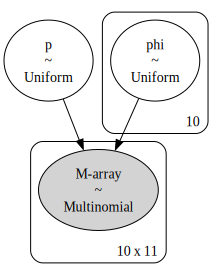

In [15]:
# utility vectors for creating arrays and array indices
intervals = np.arange(interval_count)
row_indices = np.reshape(intervals, (interval_count, 1))
col_indices = np.reshape(intervals, (1, interval_count))

# matrix indicating the number of intervals between sampling occassions
intervals_between = np.clip(col_indices - row_indices, 0, np.inf)

with pm.Model() as phit:

    # priors for catchability and survival 
    p = pm.Uniform('p', 0, 1)
    phi = pm.Uniform('phi', 0, 1, shape=interval_count)

    # broadcast phi into a matrix 
    phi_mat = pt.ones_like(number_recaptured) * phi
    phi_mat = fill_lower_diag_ones(phi_mat) # fill irrelevant values 
    
    # probability of surviving between i and j in the m-array 
    p_alive = pt.cumprod(phi_mat, axis=1)
    p_alive = pt.triu(p_alive) # select relevant (upper triangle) values

    # probability of not being captured between i and j
    p_not_cap = pt.triu((1 - p) ** intervals_between)

    # probabilities associated with each cell in the m-array
    nu = p_alive * p_not_cap * p

    # probability for the animals that were never recaptured
    chi = 1 - nu.sum(axis=1)

    # combine the probabilities into a matrix
    chi = pt.reshape(chi, (interval_count, 1))
    marr_probs = pt.horizontal_stack(nu, chi)

    # distribution of the m-array 
    marr = pm.Multinomial(
        'M-array',
        n=number_released,
        p=marr_probs,
        observed=cormorant
    )

pm.model_to_graphviz(phit)

In [16]:
with phit:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


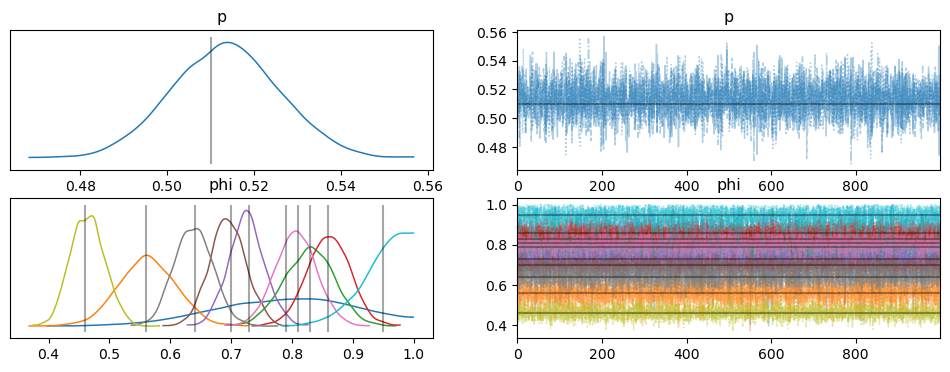

In [7]:
mccrea_p = [0.51]
mccrea_phi = [0.79, 0.56, 0.83, 0.86, 0.73, 0.70, 0.81, 0.64, 0.46, 0.95]

az.plot_trace(
    idata, 
    combined=True,
    lines=[("phi", {}, [mccrea_phi]), ("p", {}, [mccrea_p])] 
);

The model samples fairly quickly in this parameterization. The traceplots above include comparisons to the estimates from @mccrea2014. While a bit messy, the plots show a high level of agreement between their estimates and the ones here. To clean things up a bit, I plot the estimates for $\phi$ over time, along with the 94\% credible intervals

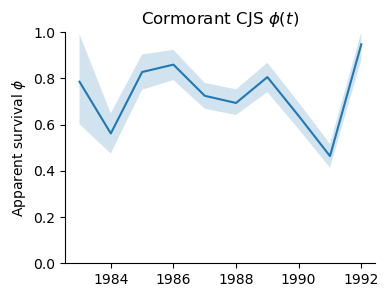

In [9]:
summary = az.summary(idata).iloc[1:,:]

phi_mean = summary.iloc[:,0]
phi_low = summary.iloc[:,2]
phi_high = summary.iloc[:,3]

t = np.arange(1983, 1993)

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(t, phi_mean)
ax.fill_between(t, phi_low, phi_high, alpha=0.2)

ax.set_ylabel(r'Apparent survival $\phi$', rotation=90)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylim((0,1))

ax.set_title(r'Cormorant CJS $\phi(t)$')

plt.show()

In [8]:
# warb = np.loadtxt('warb.csv', skiprows=1, delimiter=',')

In [10]:
# warb_full = create_full_array(warb)
# warb_full

In [11]:
# dipper = np.loadtxt('dipper.csv', skiprows=1, delimiter=',')
# dipper